In [1]:
# import required libraries
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from heapq import nlargest
from sklearn.metrics import mean_squared_error
from math import sqrt
import os.path
import scipy

import json
from scipy import sparse
%matplotlib inline


## Overview

The approach that I will be taking is to recommend users items that are similar to other items that have similar ratings based off of popularity, also known as the item-item collaborative filtering approach using cosine similarity. The methodology was taken from the following paper: https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf 

To determine the "rating" of an item relative to the user, I multiplied by the amount they purchased by the cost of the item and then took the log of that to normalize the result. The normalization prevents an expensive item having a disproportionally higher rating than a non-expensive item as well as prevents a non-expensive item bought in a large volume to have a disproportionally higher rating. In conclusion, the rating is a fucntion of both purchase volume combined with the price of the item.

#### Assumptions

Upon discovery there are products with only records of negative purchase amounts but no corresponding positive purchases. Due to the data being a snapshot and not a full dataset, only items that have postive purchase amounts will  be considered

## Import Data

In [2]:
with open('training_mixpanel.txt') as f:
    data = json.load(f)
custDF = json_normalize(data)
custDF

,event,properties.country,properties.customer_id,properties.description,properties.invoice_date,properties.invoice_no,properties.product_id,properties.quantity,properties.unit_price
0,Purchased Product,United Kingdom,17850,WHITE HANGING HEART T-LIGHT HOLDER,12/1/2010 8:26,536365,85123A,6,2.55
1,Purchased Product,United Kingdom,17850,WHITE METAL LANTERN,12/1/2010 8:26,536365,71053,6,3.39
2,Purchased Product,United Kingdom,17850,SET 7 BABUSHKA NESTING BOXES,12/1/2010 8:26,536365,22752,2,7.65
3,Purchased Product,United Kingdom,17850,GLASS STAR FROSTED T-LIGHT HOLDER,12/1/2010 8:26,536365,21730,6,4.25
4,Purchased Product,United Kingdom,17850,HAND WARMER UNION JACK,12/1/2010 8:28,536366,22633,6,1.85
5,Purchased Product,United Kingdom,17850,HAND WARMER RED POLKA DOT,12/1/2010 8:28,536366,22632,6,1.85
6,Purchased Product,United Kingdom,13047,ASSORTED COLOUR BIRD ORNAMENT,12/1/2010 8:34,536367,84879,32,1.69
7,Purchased Product,United Kingdom,13047,POPPY'S PLAYHOUSE BEDROOM,12/1/2010 8:34,536367,22745,6,2.10
8,Purchased Product,United Kingdom,13047,POPPY'S PLAYHOUSE KITCHEN,12/1/2010 8:34,536367,22748,6,2.10
9,Purchased Product,United Kingdom,13047,FELTCRAFT PRINCESS CHARLOTTE DOLL,12/1/2010 8:34,536367,22749,8,3.75


In [3]:
numItems = len(custDF['properties.product_id'].unique())
numCustomers = len(custDF['properties.customer_id'].unique())

print("Number of users:", numCustomers)
print("Number of items:", numItems)

Number of users: 4363
Number of items: 3677


## Data Preprocessing and Exploration

First we will explore the data to gain insights on some of the most popular items and customers and preprocessing the data to clean the data that is out of scope, duplicates and nulls.

In [4]:
custDF.describe()

,properties.customer_id,properties.quantity,properties.unit_price
count,322875.000000,322875.000000,322875.000000
mean,15285.738180,12.103250,2.934132
std,1712.664883,278.315144,6.228682
min,12346.000000,-80995.000000,0.000000
25%,13952.000000,2.000000,1.250000
50%,15150.000000,5.000000,1.950000
75%,16788.000000,12.000000,3.750000
max,18287.000000,80995.000000,1100.440000


Upon initial exploration, some quantity values are negative (could be indicative of an item being returned) and should be excluded from the dataset as we are only interested in items customers have purchased.

In [5]:
custDF = custDF[custDF['properties.quantity'] > 0]

Verify the dataset only contains records where the quantity purchased is greater than 0.

In [6]:
custDF.describe()

,properties.customer_id,properties.quantity,properties.unit_price
count,315955.000000,315955.000000,315955.000000
mean,15292.471308,13.161225,2.876110
std,1712.436354,201.343614,4.399119
min,12346.000000,1.000000,0.000000
25%,13969.000000,2.000000,1.250000
50%,15157.000000,6.000000,1.950000
75%,16794.000000,12.000000,3.750000
max,18287.000000,80995.000000,649.500000


Check for nulls

In [7]:
custDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315955 entries, 0 to 322874
Data columns (total 9 columns):
event                      315955 non-null object
properties.country         315955 non-null object
properties.customer_id     315955 non-null int64
properties.description     315955 non-null object
properties.invoice_date    315955 non-null object
properties.invoice_no      315955 non-null object
properties.product_id      315955 non-null object
properties.quantity        315955 non-null int64
properties.unit_price      315955 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 24.1+ MB


Check for duplicates

In [8]:
custDF.drop_duplicates().shape

(311884, 9)

Since the the number of rows are less than our original dataframe, exact duplicates of rows exist (possibly due to human error means such as double entry) and can be deleted.

In [9]:
custDF = custDF.drop_duplicates()

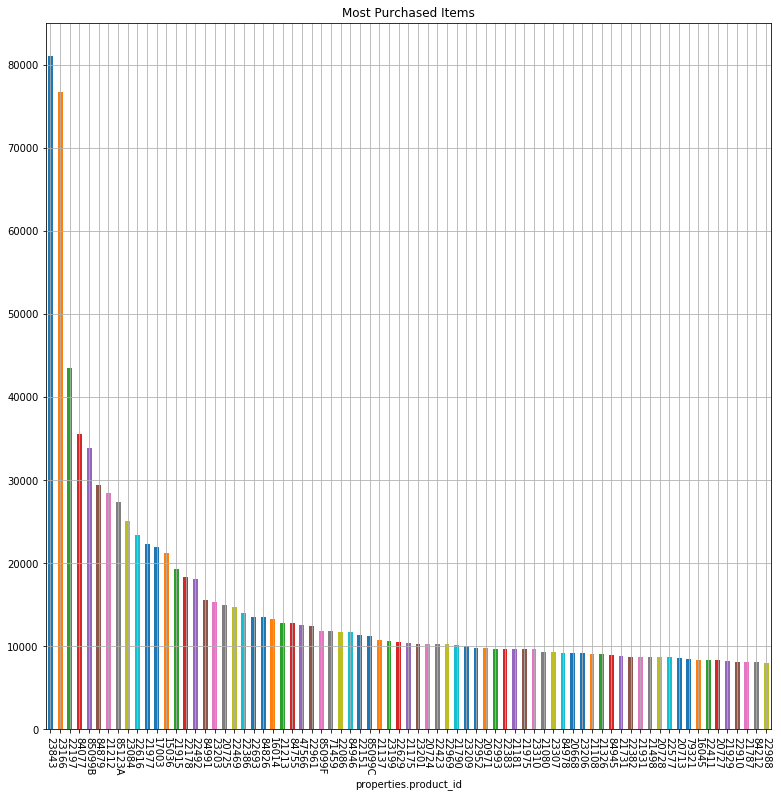

In [10]:
popItems = custDF.groupby('properties.product_id')['properties.quantity'].sum().sort_values(ascending=False)
popItems[0:75].plot(kind='bar', grid=True, rot=270, figsize=(13,13), title='Most Purchased Items')

From the data we can see that the top 10 most popular items make up for a vast majority of the items purchased, but does that correlate to an item being higher rated.

Graph the number of unique items bought per customer

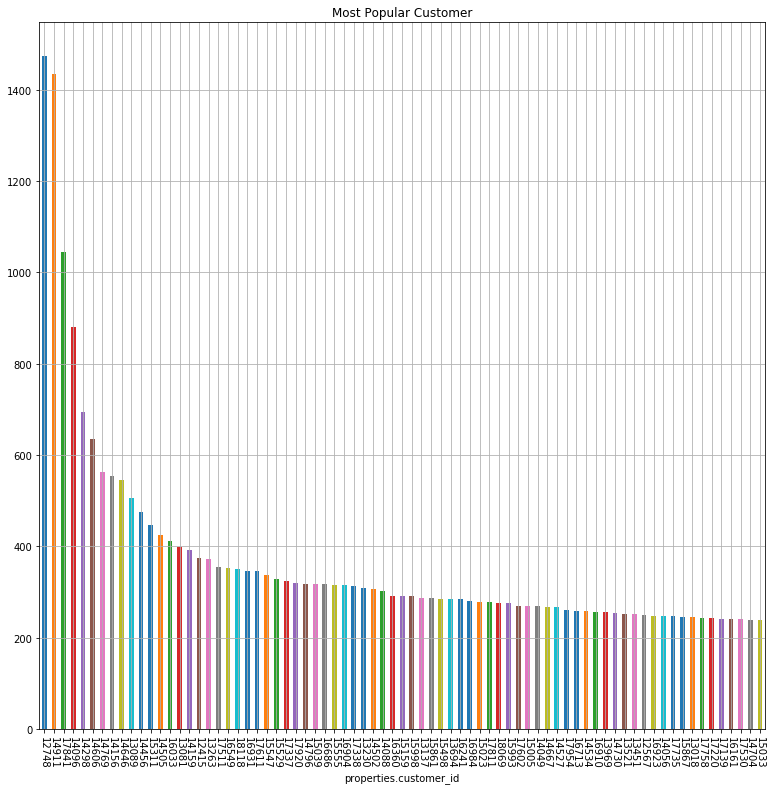

In [11]:
popCustomers = custDF.groupby('properties.customer_id')['properties.product_id'].nunique().sort_values(ascending=False)
popCustomers[0:75].plot(kind='bar', grid=True, rot=270, figsize=(13,13), title='Most Popular Customer')

Other than 10 customers, majority of the customer fall under 400 unique items bought.

Caclulate Rating for each transaction

c:\users\ashto\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


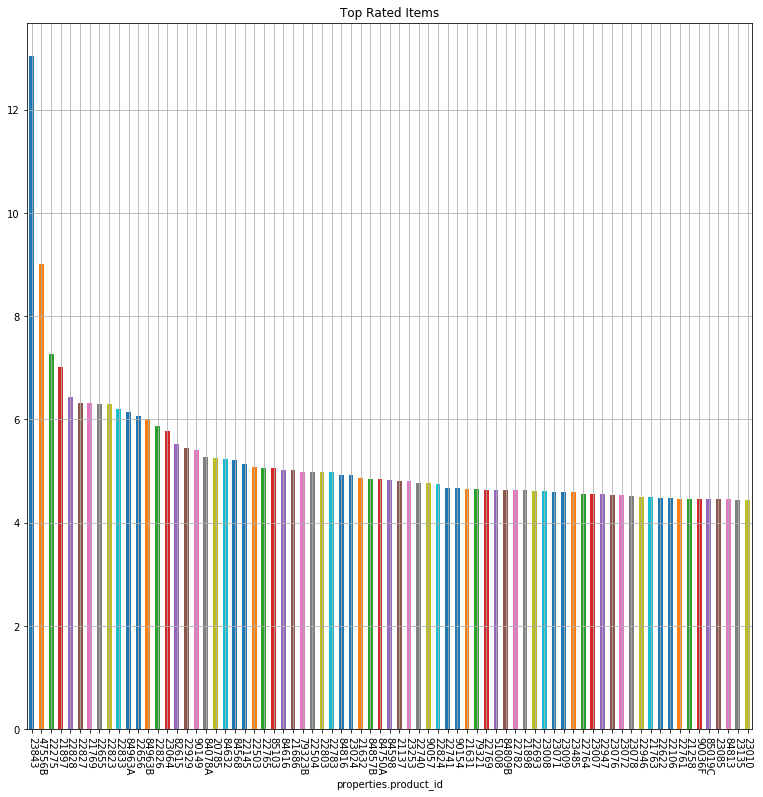

In [12]:
custDF['popRating'] = 1 + np.log(np.array(custDF['properties.quantity']) * np.array(custDF['properties.unit_price']))
itemRating = custDF.groupby('properties.product_id')['popRating'].mean().sort_values(ascending=False)
itemRating[0:75].plot(kind='bar', grid=True, rot=270, figsize=(13,13), title='Top Rated Items')

Item 23843 is the highest raiting item and is the also the most bought item, however the 2nd most bought item is not the 2nd highest rated item.

## Item-Item Collaborative Filtering

Caclulate rating for each user by taking the average rating for an item over multiple transactions.

In [13]:
avgCustRating = custDF.groupby(['properties.customer_id', 'properties.product_id'])['popRating'].mean().reset_index()

In [14]:
avgCustRating.describe()

,properties.customer_id,popRating
count,212995.000000,2.129950e+05
mean,15273.910899,-inf
std,1710.864276,NaN
min,12346.000000,-inf
25%,13862.000000,2.599388e+00
50%,15214.000000,3.459589e+00
75%,16771.000000,3.882004e+00
max,18287.000000,1.303451e+01


Replace all -infinities with 0

In [15]:
avgCustRating = avgCustRating.replace([-np.inf], 0)

In [16]:
avgCustRating.describe()

,properties.customer_id,popRating
count,212995.000000,212995.000000
mean,15273.910899,3.255884
std,1710.864276,1.099038
min,12346.000000,-1.302585
25%,13862.000000,2.599388
50%,15214.000000,3.459589
75%,16771.000000,3.882004
max,18287.000000,13.034511


In [17]:
index = [tuple(item) for item in avgCustRating.values]

Initialize the user-item matrix

In [18]:
popDF = pd.DataFrame(0,columns=custDF['properties.product_id'].unique(), index=custDF['properties.customer_id'].unique())
popDF = popDF.astype(float)

The user-item matrix is filled by the average rating for a product determined by the rating function for a customer

In [19]:
#index = list(zip(list(avgCustRating['properties.customer_id']), list(avgCustRating['properties.product_id'])))
for item in index:
    popDF.at[item[0], item[1]] = float(item[2])

In [20]:
popDF

,85123A,71053,22752,21730,22633,22632,84879,22745,22748,22749,...,90214O,90214T,90214U,90214V,90214W,90214Z,84805A,85225,90089,23843
17850,3.875667,4.151832,3.944461,4.224822,3.447718,3.447718,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
13047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990464,3.533697,3.533697,4.054624,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
12583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
13748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
15100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
15291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.604170,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
14688,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
15311,0.000000,0.000000,3.441529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
16098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
18074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [21]:
def calculateSimilarity(popDF):
    '''
    Calculate the column-wise cosine similarity for a sparse matrix.
    Return a new dataframe matrix with similarities.
    
    Inputs:
    
    popDF (DataFrame): User-Item ratings dataframe
    
    Outputs:
    
    sim (DataFrame): Item-Item Similarity dataframe
    '''
    sparseData = sparse.csr_matrix(popDF)
    similarities = cosine_similarity(sparseData.transpose())
    sim = pd.DataFrame(data=similarities, index=popDF.columns, columns= popDF.columns)
    return sim

In [22]:
itemSimilarity = calculateSimilarity(popDF) #pairwise_distances(trainMatrix.T, metric='cosine')

In [23]:
itemSimilarity

,85123A,71053,22752,21730,22633,22632,84879,22745,22748,22749,...,90214O,90214T,90214U,90214V,90214W,90214Z,84805A,85225,90089,23843
85123A,1.000000,0.183599,0.098064,0.149825,0.141324,0.145108,0.251633,0.107299,0.082278,0.156839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.034389,0.0
71053,0.183599,1.000000,0.062433,0.089425,0.111627,0.110726,0.114612,0.072934,0.079612,0.066002,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
22752,0.098064,0.062433,1.000000,0.084117,0.072013,0.121197,0.117783,0.139938,0.131410,0.091656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
21730,0.149825,0.089425,0.084117,1.000000,0.045621,0.090841,0.047689,0.015185,0.032369,0.062696,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
22633,0.141324,0.111627,0.072013,0.045621,1.000000,0.315543,0.121202,0.066526,0.066356,0.129869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
22632,0.145108,0.110726,0.121197,0.090841,0.315543,1.000000,0.115137,0.098561,0.091304,0.086098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
84879,0.251633,0.114612,0.117783,0.047689,0.121202,0.115137,1.000000,0.119239,0.110496,0.090518,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
22745,0.107299,0.072934,0.139938,0.015185,0.066526,0.098561,0.119239,1.000000,0.683859,0.193573,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
22748,0.082278,0.079612,0.131410,0.032369,0.066356,0.091304,0.110496,0.683859,1.000000,0.212074,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
22749,0.156839,0.066002,0.091656,0.062696,0.129869,0.086098,0.090518,0.193573,0.212074,1.000000,...,0.070376,0.070376,0.070376,0.070376,0.070376,0.070376,0.0,0.0,0.000000,0.0


In [24]:
def predictByItemSimilarity(trainSet, numUsers, numItems, similarity):
    
    '''
    Uses the similarity matrix to predict rating scores for every user for each item.
    
    Inputs:
    
    trainSet (Numpy Array): Item-User matrix
    numUsers (int): Number of users
    numItems (int): Number of items
    similarity (Numpy Array): Item-Item similarity matrix
    
    Ouput:
    
    predictionMatrix (Numpy Array): User-Item matrix with predicted ratings for each user and product.
    
    '''
    # Initialize the predicted rating matrix with zeros
    predictionMatrix = np.zeros((numItems, numUsers))
    
    for (item,user), rating in np.ndenumerate(trainSet):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
        if rating == 0:
            # Extract the items that were bought by users
            itemVector = trainSet[:,user]
            
            itemRatings = itemVector[itemVector.nonzero()]
            
            # Get the similarity score for each of the items that were bought by users
           
            itemsSim = similarity[item,:][itemVector.nonzero()]
            # If there no users bought any items, use item's average
            if len(itemsSim) == 0:
                itemVector = trainSet[item, :]
                ratedItems = itemVector[itemVector.nonzero()]
                
                # If the items werent rated use 0, otherwise use average
                if len(ratedItems) == 0:
                    predictionMatrix[item,user] = 0
                else:
                    predictionMatrix[item,user] = ratedItems.mean()
            else:
                # predict score based on item-item similarity
                if(itemsSim.sum() == 0):
                    predictionMatrix[item,user] = 0
                else:
                    predictionMatrix[item,user] = (itemRatings*itemsSim).sum() / itemsSim.sum()
        
        # report progress every 100 items
        if (item % 100 == 0 and user == 1):
            print ("calculated %d items" % (item,))
    

    return predictionMatrix

Caclulate the similarity between items using the cosine similarity metric (in this case due to the normalization of our data we get the Pearson Correlation)

In [25]:
numItems = popDF.shape[1]
numCustomers = popDF.shape[0]

predictionMatrix = predictByItemSimilarity(popDF.T.as_matrix(), numCustomers, numItems, itemSimilarity.as_matrix())

c:\users\ashto\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


calculated 0 items
calculated 100 items
calculated 200 items
calculated 300 items
calculated 400 items
calculated 500 items
calculated 600 items
calculated 700 items
calculated 800 items
calculated 900 items
calculated 1000 items
calculated 1100 items
calculated 1200 items
calculated 1300 items
calculated 1400 items
calculated 1500 items
calculated 1600 items
calculated 1700 items
calculated 1800 items
calculated 1900 items
calculated 2000 items
calculated 2100 items
calculated 2200 items
calculated 2300 items
calculated 2400 items
calculated 2500 items
calculated 2600 items
calculated 2700 items
calculated 2800 items
calculated 2900 items
calculated 3000 items
calculated 3100 items
calculated 3200 items
calculated 3300 items
calculated 3400 items
calculated 3500 items
calculated 3600 items


In [26]:
predictionDF = pd.DataFrame(predictionMatrix.T, columns=popDF.columns, index=popDF.index)

In [38]:
predictionDF.to_csv('output.csv', float_format='%3f')